In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve

In [119]:
# load dataset
cols = ["max", "min", "wind", "humidi", "pressure", "rain"]
data = pd.read_csv('./weather.csv', usecols=cols)

# filter NaN
data = data.dropna()

# convert categorical data to numeric
data = pd.get_dummies(data, drop_first=True)
print(data.head(200))

     max  min  wind  rain  humidi  pressure
0     29   22     6  18.5      89      1010
1     34   24     5   0.0      59      1010
2     29   23     4   0.2      81      1008
3     32   23     7   1.8      76      1012
4     33   24     4   0.0      69      1010
..   ...  ...   ...   ...     ...       ...
195   33   23     7   0.0      62      1015
196   32   22     3   1.4      76      1009
197   32   24     7   2.6      75      1010
198   33   23     6   0.1      73      1011
199   33   23     5   0.4      71      1012

[200 rows x 6 columns]


In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   max       3548 non-null   int64  
 1   min       3548 non-null   int64  
 2   wind      3548 non-null   int64  
 3   rain      3548 non-null   float64
 4   humidi    3548 non-null   int64  
 5   pressure  3548 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 166.4 KB


In [121]:
### Pre-processing data
X = data[["max", "min", "wind", "humidi", "pressure"]]
y = data["rain"]
y = (y > 0).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()

In [122]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train, '\n', X_test, '\n', y_train, '\n', y_test)

[[-0.13412644  1.53311367  2.11346388 -0.1465236  -0.05223578]
 [ 0.64910575  0.32869108  0.63247364 -0.42294769 -0.05223578]
 [ 0.64910575  2.13532497  0.63247364 -0.97579586  0.40815283]
 ...
 [-0.13412644  0.93090238  0.04007754  0.12990049 -0.05223578]
 [-0.52574254 -0.27352021  0.33627559  0.86703139 -0.97301299]
 [-0.13412644 -0.8757315   0.63247364 -0.33080632  1.32893005]] 
 [[-1.30897473 -0.27352021 -1.14471466  1.78844502  0.86854144]
 [ 0.25748965 -1.4779428  -1.44091271 -0.69937177  1.32893005]
 [ 0.25748965  0.32869108  0.92867169  0.22204185 -0.51262439]
 ...
 [-0.13412644 -0.27352021 -0.55231856  0.31418322  0.40815283]
 [-1.70059083 -0.27352021  1.81726584  1.23559685 -0.97301299]
 [ 0.25748965 -0.27352021 -1.14471466 -0.60723041 -0.51262439]] 
 1878    1
1315    1
1348    1
825     0
1371    1
       ..
1112    1
3384    1
2024    1
2658    1
681     1
Name: rain, Length: 2838, dtype: int64 
 3448    1
404     0
3128    1
954     1
261     1
       ..
2858    1
3080   

In [123]:
model = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [124]:
y_prob = model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Find the threshold for predicting rain using the F1 formula to reduce FN (False negative)
f1 = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_threshold = thresholds[np.argmax(f1)]

print("Chosen threshold:", best_threshold)

Chosen threshold: 0.2782977541232734


In [125]:
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > best_threshold).astype(int)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Confusion Matrix:
 [[147  32]
 [ 36 495]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       179
           1       0.94      0.93      0.94       531

    accuracy                           0.90       710
   macro avg       0.87      0.88      0.87       710
weighted avg       0.90      0.90      0.90       710



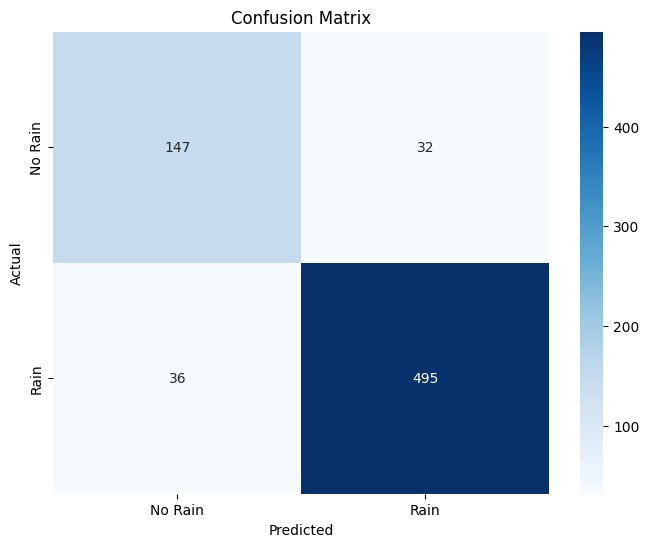

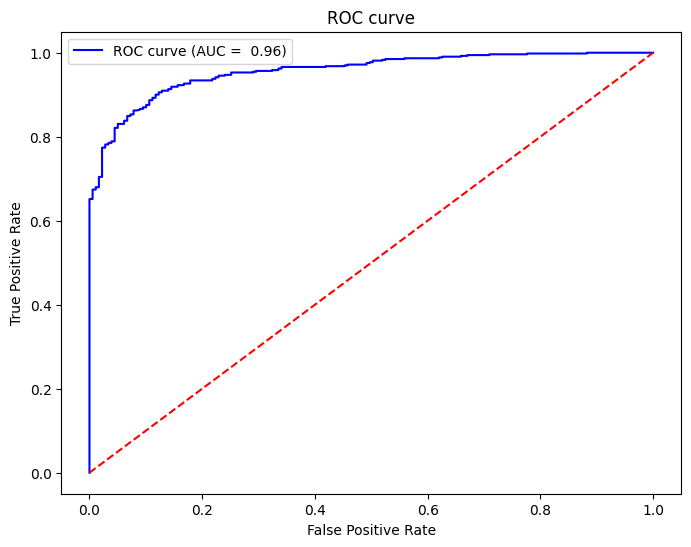

In [126]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc: .2f})")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

In [127]:
# save the model
joblib.dump((model, scaler), 'rain_prediction.pkl')
print('Model saved successfully')

Model saved successfully


In [139]:
loaded_model, loaded_scaler = joblib.load("rain_prediction.pkl")
print("Model loaded successfully")

# Example test data
data = pd.read_csv("test.csv")

new_data = data[["max", "min", "wind", "humidi", "pressure"]]

# Standardize the new data using the same scaler used for training
new_data_standardized = loaded_scaler.transform(new_data)

# Make predictions
predictions = model.predict(new_data_standardized)
probabilities = model.predict_proba(new_data_standardized)[:, 1]

for i in range(len(predictions)):
    print(f"Prediction: {"Yes" if predictions[i] == 1 else "No"} - Confidence: {probabilities[i]:.2f}")

Model loaded successfully
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 0.99
Prediction: Yes - Confidence: 0.97
Prediction: Yes - Confidence: 0.98
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 0.99
Prediction: Yes - Confidence: 0.96
Prediction: Yes - Confidence: 0.98
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 0.99
Prediction: Yes - Confidence: 0.98
Prediction: Yes - Confidence: 0.99
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 0.98
Prediction: Yes - Confidence: 0.99
Prediction: Yes - Confidence: 0.94
Prediction: Yes - Confidence: 0.97
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 1.00
Prediction: Yes - Confidence: 0.99
Prediction: Yes - Confidence: